In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score 


%cd C:\Users\Harika\Documents\ML & AI

C:\Users\Harika\Documents\ML & AI


Reading and Understanding the Data

In [4]:
df = pd.read_csv('CarPrice_Assignment.csv')

In [4]:
df.head()

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   
2        mpfi       2.68    3.47              9.0        154     5000      19   
3        mpfi       3.19    3.40             10.0        102     5500      24   
4        mpfi       3.19    3.40              8.0        115     5500      18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 26 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [5]:
pp.ProfileReport(df)

Data Cleaning and Preparation

In [7]:
#Splitting the car company and the model from carname columns
df['CarName'] = df['CarName'].str.lower()
split_df = df['CarName'].str.split(n = 1, expand = True)
df['company_name'] = split_df[0]
df['Model'] = split_df[1]

In [8]:
#correcting the spellings or fixing invalid values
df['company_name'] = df.company_name.replace(to_replace=['vw' , 'toyouta' , 'porcshce', 'vokswagen', 'maxda'],value=['volkswagen' , 'toyota', 'porsche', 'volkswagen', 'mazda'])
df['fuelsystem'] = df.fuelsystem.replace(to_replace = ['spfi','mfi'],value=['spdi','mpfi'])

In [9]:
#Dropping unwanted columns
df = df.drop(['car_ID','CarName', 'Model'], axis = 1)

Visualising Numeric Variables

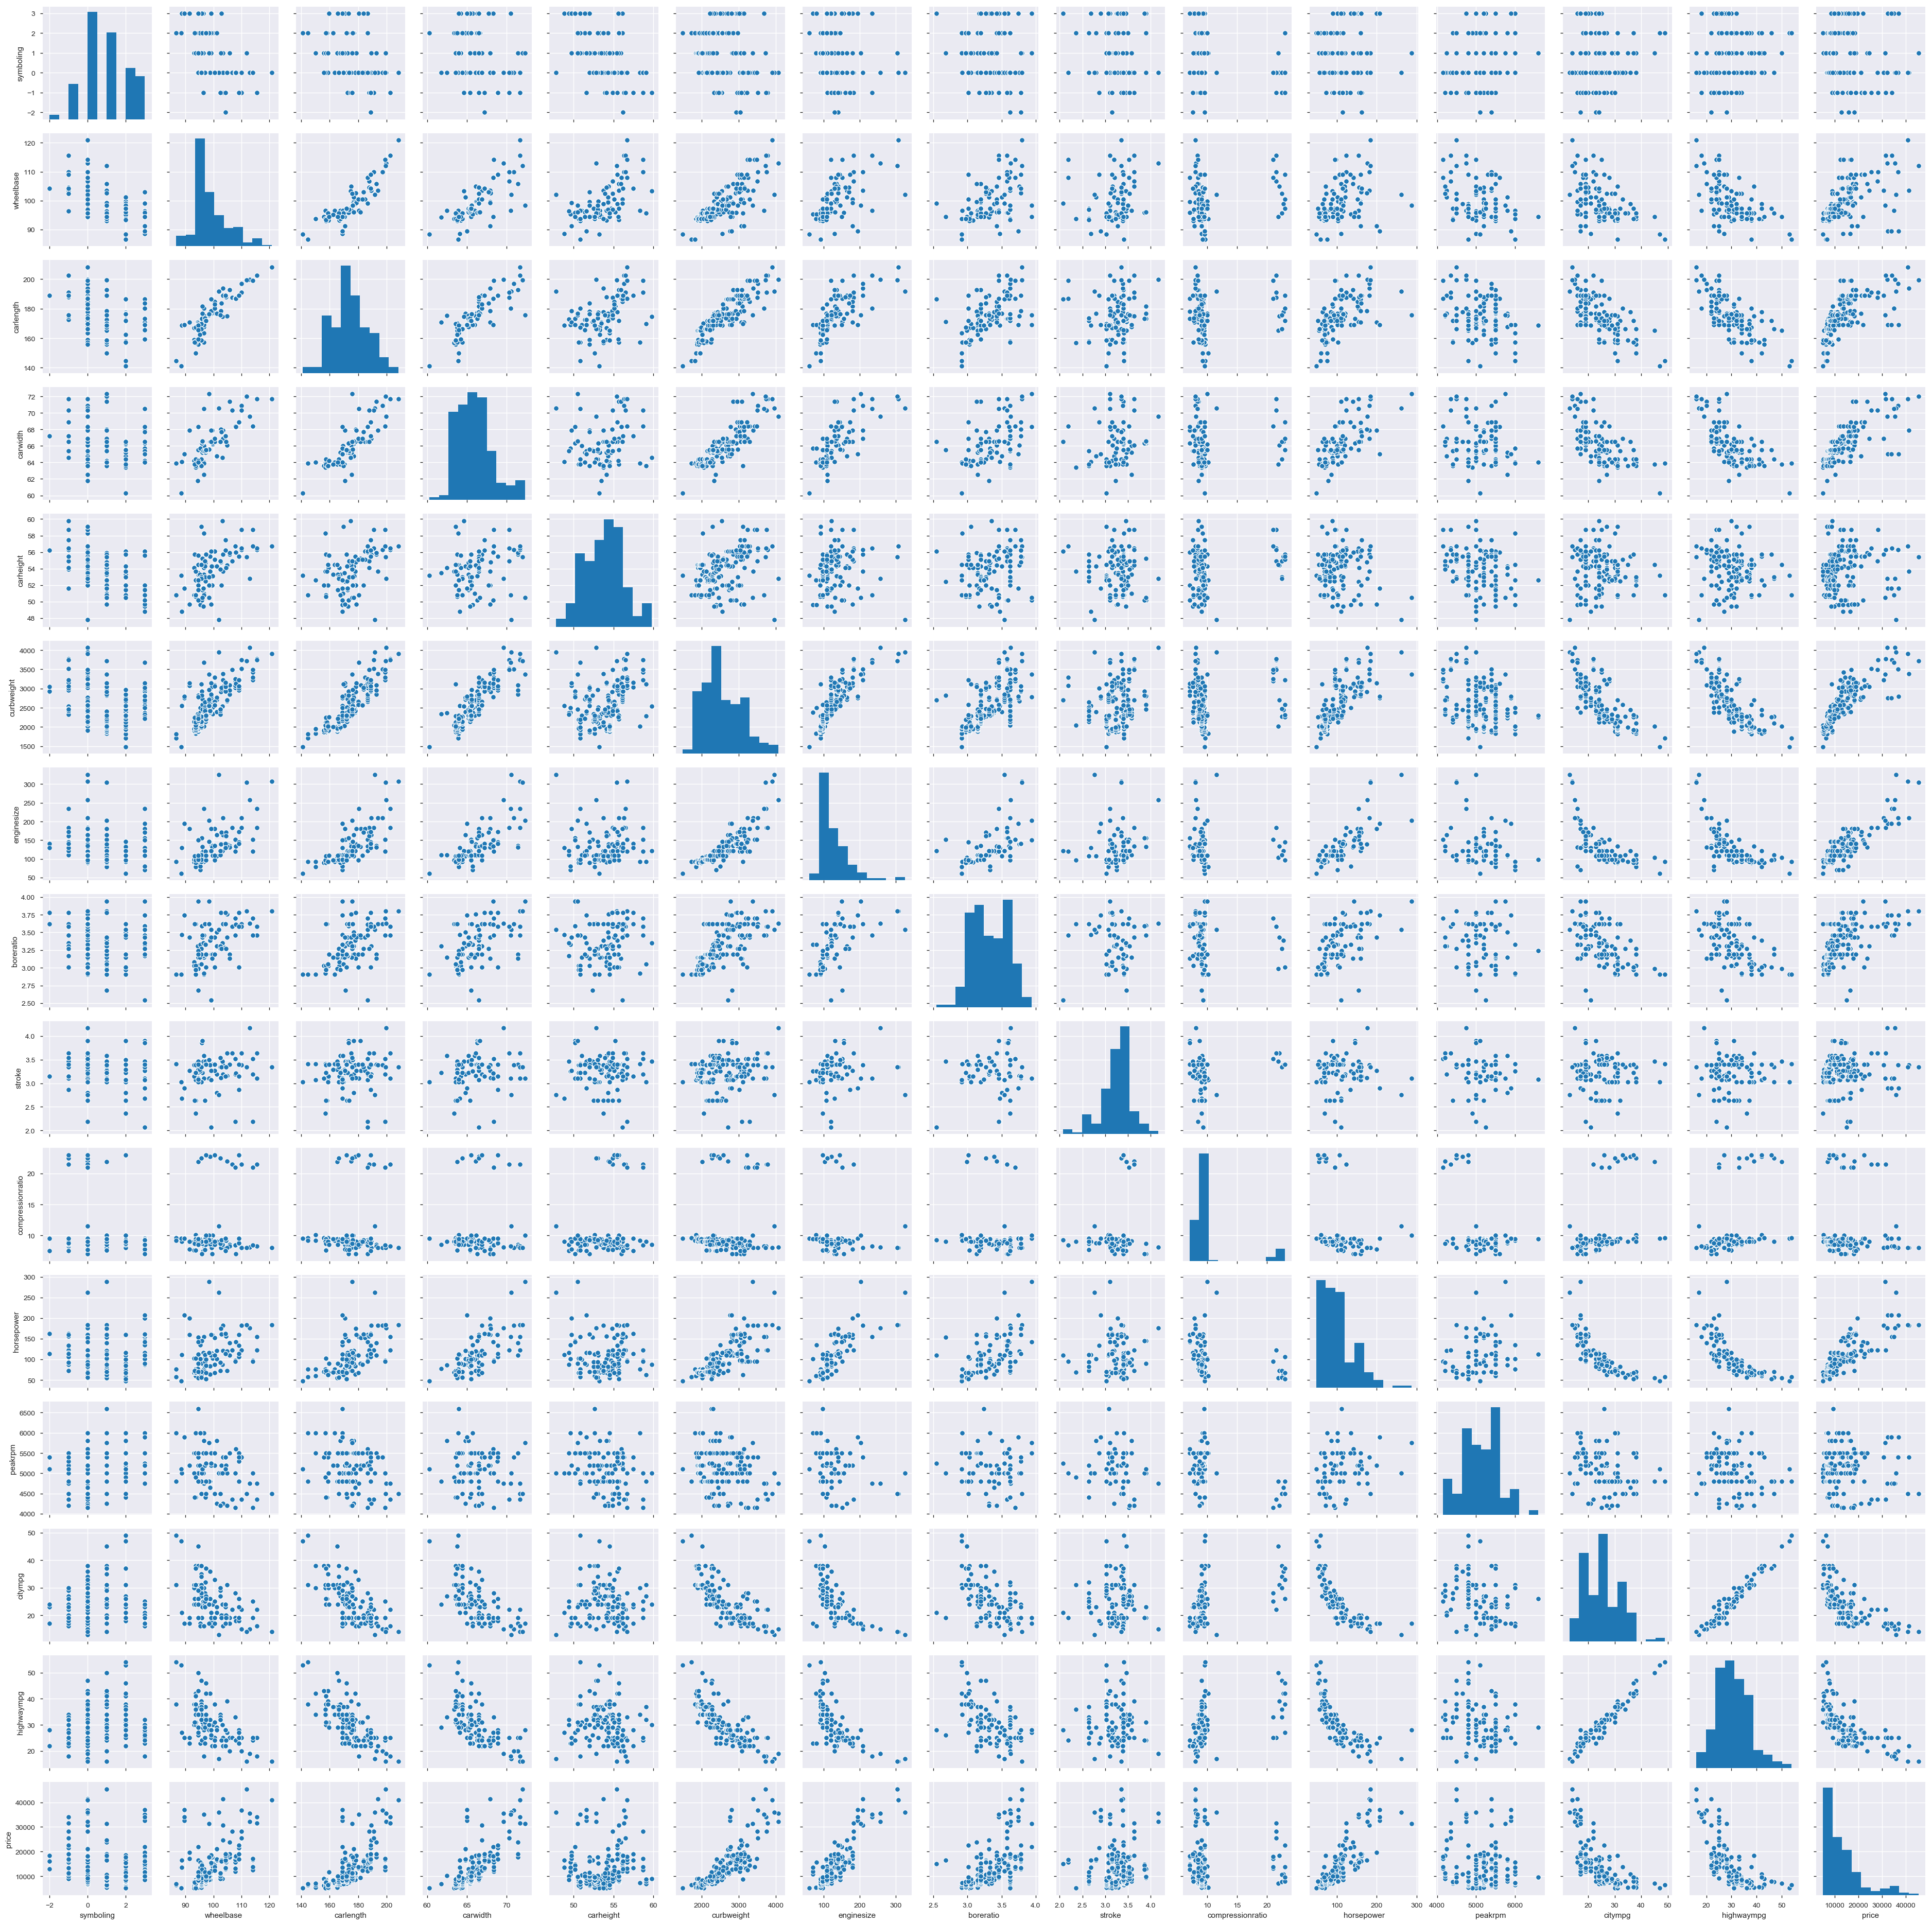

In [10]:
sns.pairplot(df)
plt.show()

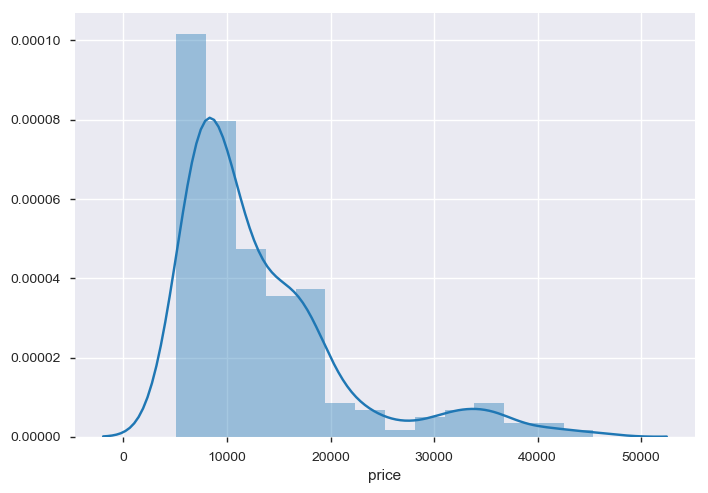

In [11]:
sns.distplot(df['price'])

Visualising Categorical Variables

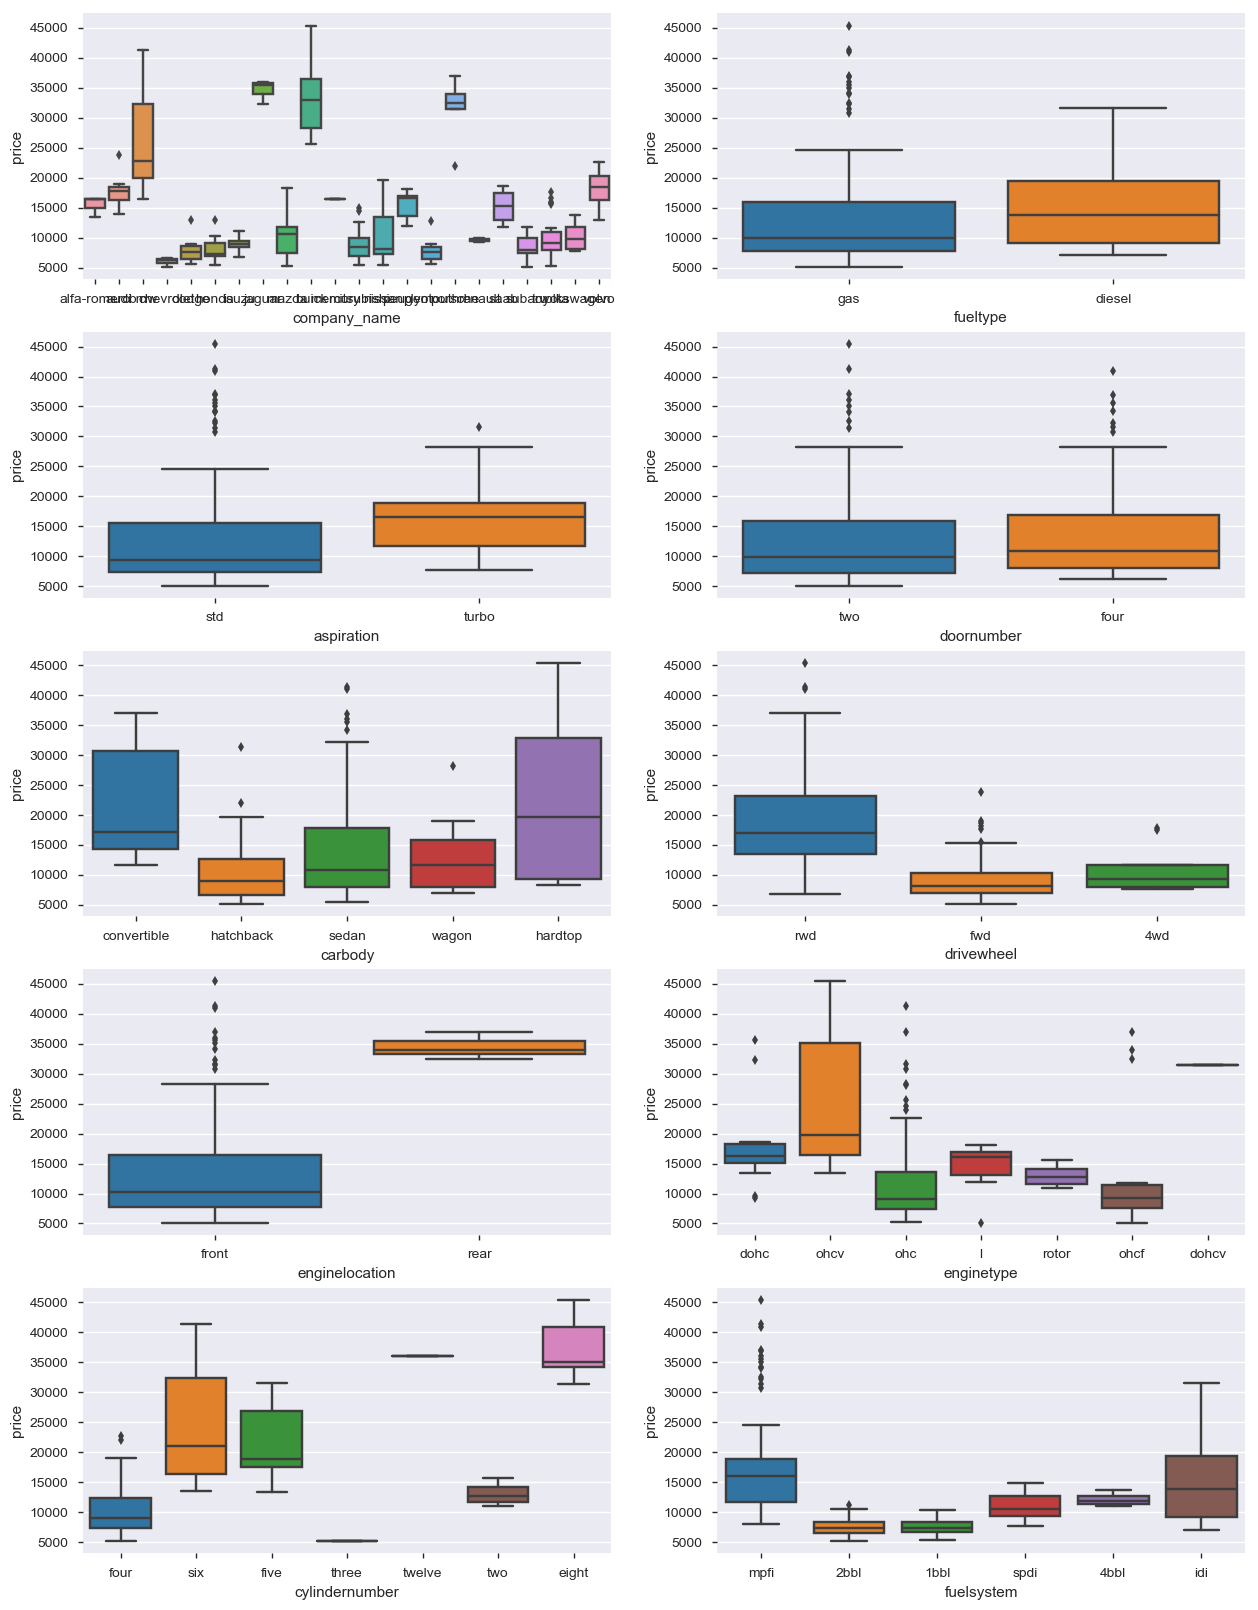

In [13]:
f, axes = plt.subplots(5, 2,figsize=(15,20))
sns.boxplot(x = 'company_name', y = 'price', data = df, orient='v' , ax=axes[0,0])
sns.boxplot(x = 'fueltype', y = 'price', data = df, orient='v' , ax=axes[0,1])
sns.boxplot(x = 'aspiration', y = 'price', data = df, orient='v' , ax=axes[1,0])
sns.boxplot(x = 'doornumber', y = 'price', data = df, orient='v' , ax=axes[1,1])
sns.boxplot(x = 'carbody', y = 'price', data = df, orient='v' , ax=axes[2,0])
sns.boxplot(x = 'drivewheel', y = 'price', data = df, orient='v' , ax=axes[2,1])
sns.boxplot(x = 'enginelocation', y = 'price', data = df, orient='v' , ax=axes[3,0])
sns.boxplot(x = 'enginetype', y = 'price', data = df, orient='v' , ax=axes[3,1])
sns.boxplot(x = 'cylindernumber', y = 'price', data = df, orient='v' , ax=axes[4,0])
sns.boxplot(x = 'fuelsystem', y = 'price', data = df, orient='v' , ax=axes[4,1])

In [14]:
#Dataframe with list of significant variables after visual analysis
lr_vars = df[['price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase',
                  'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 
                    'carlength','carwidth']]

In [15]:
# Creating Dummy variables
lr_vars = pd.get_dummies(lr_vars, columns=['fueltype', 'aspiration', 'carbody',
       'drivewheel', 'enginetype', 'cylindernumber'], drop_first=True)


In [16]:
lr_vars.head()

price  wheelbase  curbweight  enginesize  boreratio  horsepower  \
0  13495.0       88.6        2548         130       3.47         111   
1  16500.0       88.6        2548         130       3.47         111   
2  16500.0       94.5        2823         152       2.68         154   
3  13950.0       99.8        2337         109       3.19         102   
4  17450.0       99.4        2824         136       3.19         115   

   carlength  carwidth  fueltype_gas  aspiration_turbo  ...  enginetype_ohc  \
0      168.8      64.1             1                 0  ...               0   
1      168.8      64.1             1                 0  ...               0   
2      171.2      65.5             1                 0  ...               0   
3      176.6      66.2             1                 0  ...               1   
4      176.6      66.4             1                 0  ...               1   

   enginetype_ohcf  enginetype_ohcv  enginetype_rotor  cylindernumber_five  \
0                0                0                 0                    0   
1                0                0                 0                    0   
2                0                1                 0                    0   
3                0                0                 0                    0   
4                0                0                 0                    1   

   cylindernumber_four  cylindernumber_six  cylindernumber_three  \
0                    1                   0                     0   
1                    1                   0                     0   
2                    0                   1                     0   
3                    1                   0                     0   
4                    0                   0                     0   

   cylindernumber_twelve  cylindernumber_two  
0                      0                   0  
1                      0                   0  
2                      0                   0  
3                      0                   0  
4                      0                   0  

[5 rows x 28 columns]

Splitting the Data into Training and Testing Sets

In [17]:
np.random.seed(0)
df_train, df_test = train_test_split(lr_vars, train_size = 0.7, test_size = 0.3, random_state = 100)

In [18]:
#Scaling the categorical variables
scaler = MinMaxScaler()
variables = df_train.select_dtypes(include =['float64', 'int64'])
var_cols = variables.columns
df_train[var_cols] = scaler.fit_transform(df_train[var_cols])

C:\Users\Harika\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [19]:
df_train.head()

price  wheelbase  curbweight  enginesize  boreratio  horsepower  \
122  0.068818   0.244828    0.272692    0.139623   0.230159    0.083333   
125  0.466890   0.272414    0.500388    0.339623   1.000000    0.395833   
166  0.122110   0.272414    0.314973    0.139623   0.444444    0.266667   
1    0.314446   0.068966    0.411171    0.260377   0.626984    0.262500   
199  0.382131   0.610345    0.647401    0.260377   0.746032    0.475000   

     carlength  carwidth  fueltype_gas  aspiration_turbo  ...  enginetype_ohc  \
122   0.426016  0.291667             1                 0  ...               1   
125   0.452033  0.666667             1                 0  ...               1   
166   0.448780  0.308333             1                 0  ...               0   
1     0.450407  0.316667             1                 0  ...               0   
199   0.775610  0.575000             1                 1  ...               1   

     enginetype_ohcf  enginetype_ohcv  enginetype_rotor  cylindernumber_five  \
122                0                0                 0                    0   
125                0                0                 0                    0   
166                0                0                 0                    0   
1                  0                0                 0                    0   
199                0                0                 0                    0   

     cylindernumber_four  cylindernumber_six  cylindernumber_three  \
122                    1                   0                     0   
125                    1                   0                     0   
166                    1                   0                     0   
1                      1                   0                     0   
199                    1                   0                     0   

     cylindernumber_twelve  cylindernumber_two  
122                      0                   0  
125                      0                   0  
166                      0                   0  
1                        0                   0  
199                      0                   0  

[5 rows x 28 columns]

In [20]:
df_train.describe()

price   wheelbase  curbweight  enginesize   boreratio  horsepower  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     0.219310    0.411141    0.407878    0.241351    0.497946    0.227302   
std      0.215682    0.205581    0.211269    0.154619    0.207140    0.165511   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.067298    0.272414    0.245539    0.135849    0.305556    0.091667   
50%      0.140343    0.341379    0.355702    0.184906    0.500000    0.191667   
75%      0.313479    0.503448    0.559542    0.301887    0.682540    0.283333   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        carlength    carwidth  fueltype_gas  aspiration_turbo  ...  \
count  143.000000  143.000000    143.000000        143.000000  ...   
mean     0.525476    0.461655      0.909091          0.181818  ...   
std      0.204848    0.184517      0.288490          0.387050  ...   
min      0.000000    0.000000      0.000000          0.000000  ...   
25%      0.399187    0.304167      1.000000          0.000000  ...   
50%      0.502439    0.425000      1.000000          0.000000  ...   
75%      0.669919    0.550000      1.000000          0.000000  ...   
max      1.000000    1.000000      1.000000          1.000000  ...   

       enginetype_ohc  enginetype_ohcf  enginetype_ohcv  enginetype_rotor  \
count      143.000000       143.000000       143.000000        143.000000   
mean         0.685315         0.083916         0.062937          0.027972   
std          0.466023         0.278236         0.243703          0.165472   
min          0.000000         0.000000         0.000000          0.000000   
25%          0.000000         0.000000         0.000000          0.000000   
50%          1.000000         0.000000         0.000000          0.000000   
75%          1.000000         0.000000         0.000000          0.000000   
max          1.000000         1.000000         1.000000          1.000000   

       cylindernumber_five  cylindernumber_four  cylindernumber_six  \
count           143.000000           143.000000          143.000000   
mean              0.062937             0.741259            0.132867   
std               0.243703             0.439483            0.340624   
min               0.000000             0.000000            0.000000   
25%               0.000000             0.000000            0.000000   
50%               0.000000             1.000000            0.000000   
75%               0.000000             1.000000            0.000000   
max               1.000000             1.000000            1.000000   

       cylindernumber_three  cylindernumber_twelve  cylindernumber_two  
count            143.000000             143.000000          143.000000  
mean               0.006993               0.006993            0.027972  
std                0.083624               0.083624            0.165472  
min                0.000000               0.000000            0.000000  
25%                0.000000               0.000000            0.000000  
50%                0.000000               0.000000            0.000000  
75%                0.000000               0.000000            0.000000  
max                1.000000               1.000000            1.000000  

[8 rows x 28 columns]

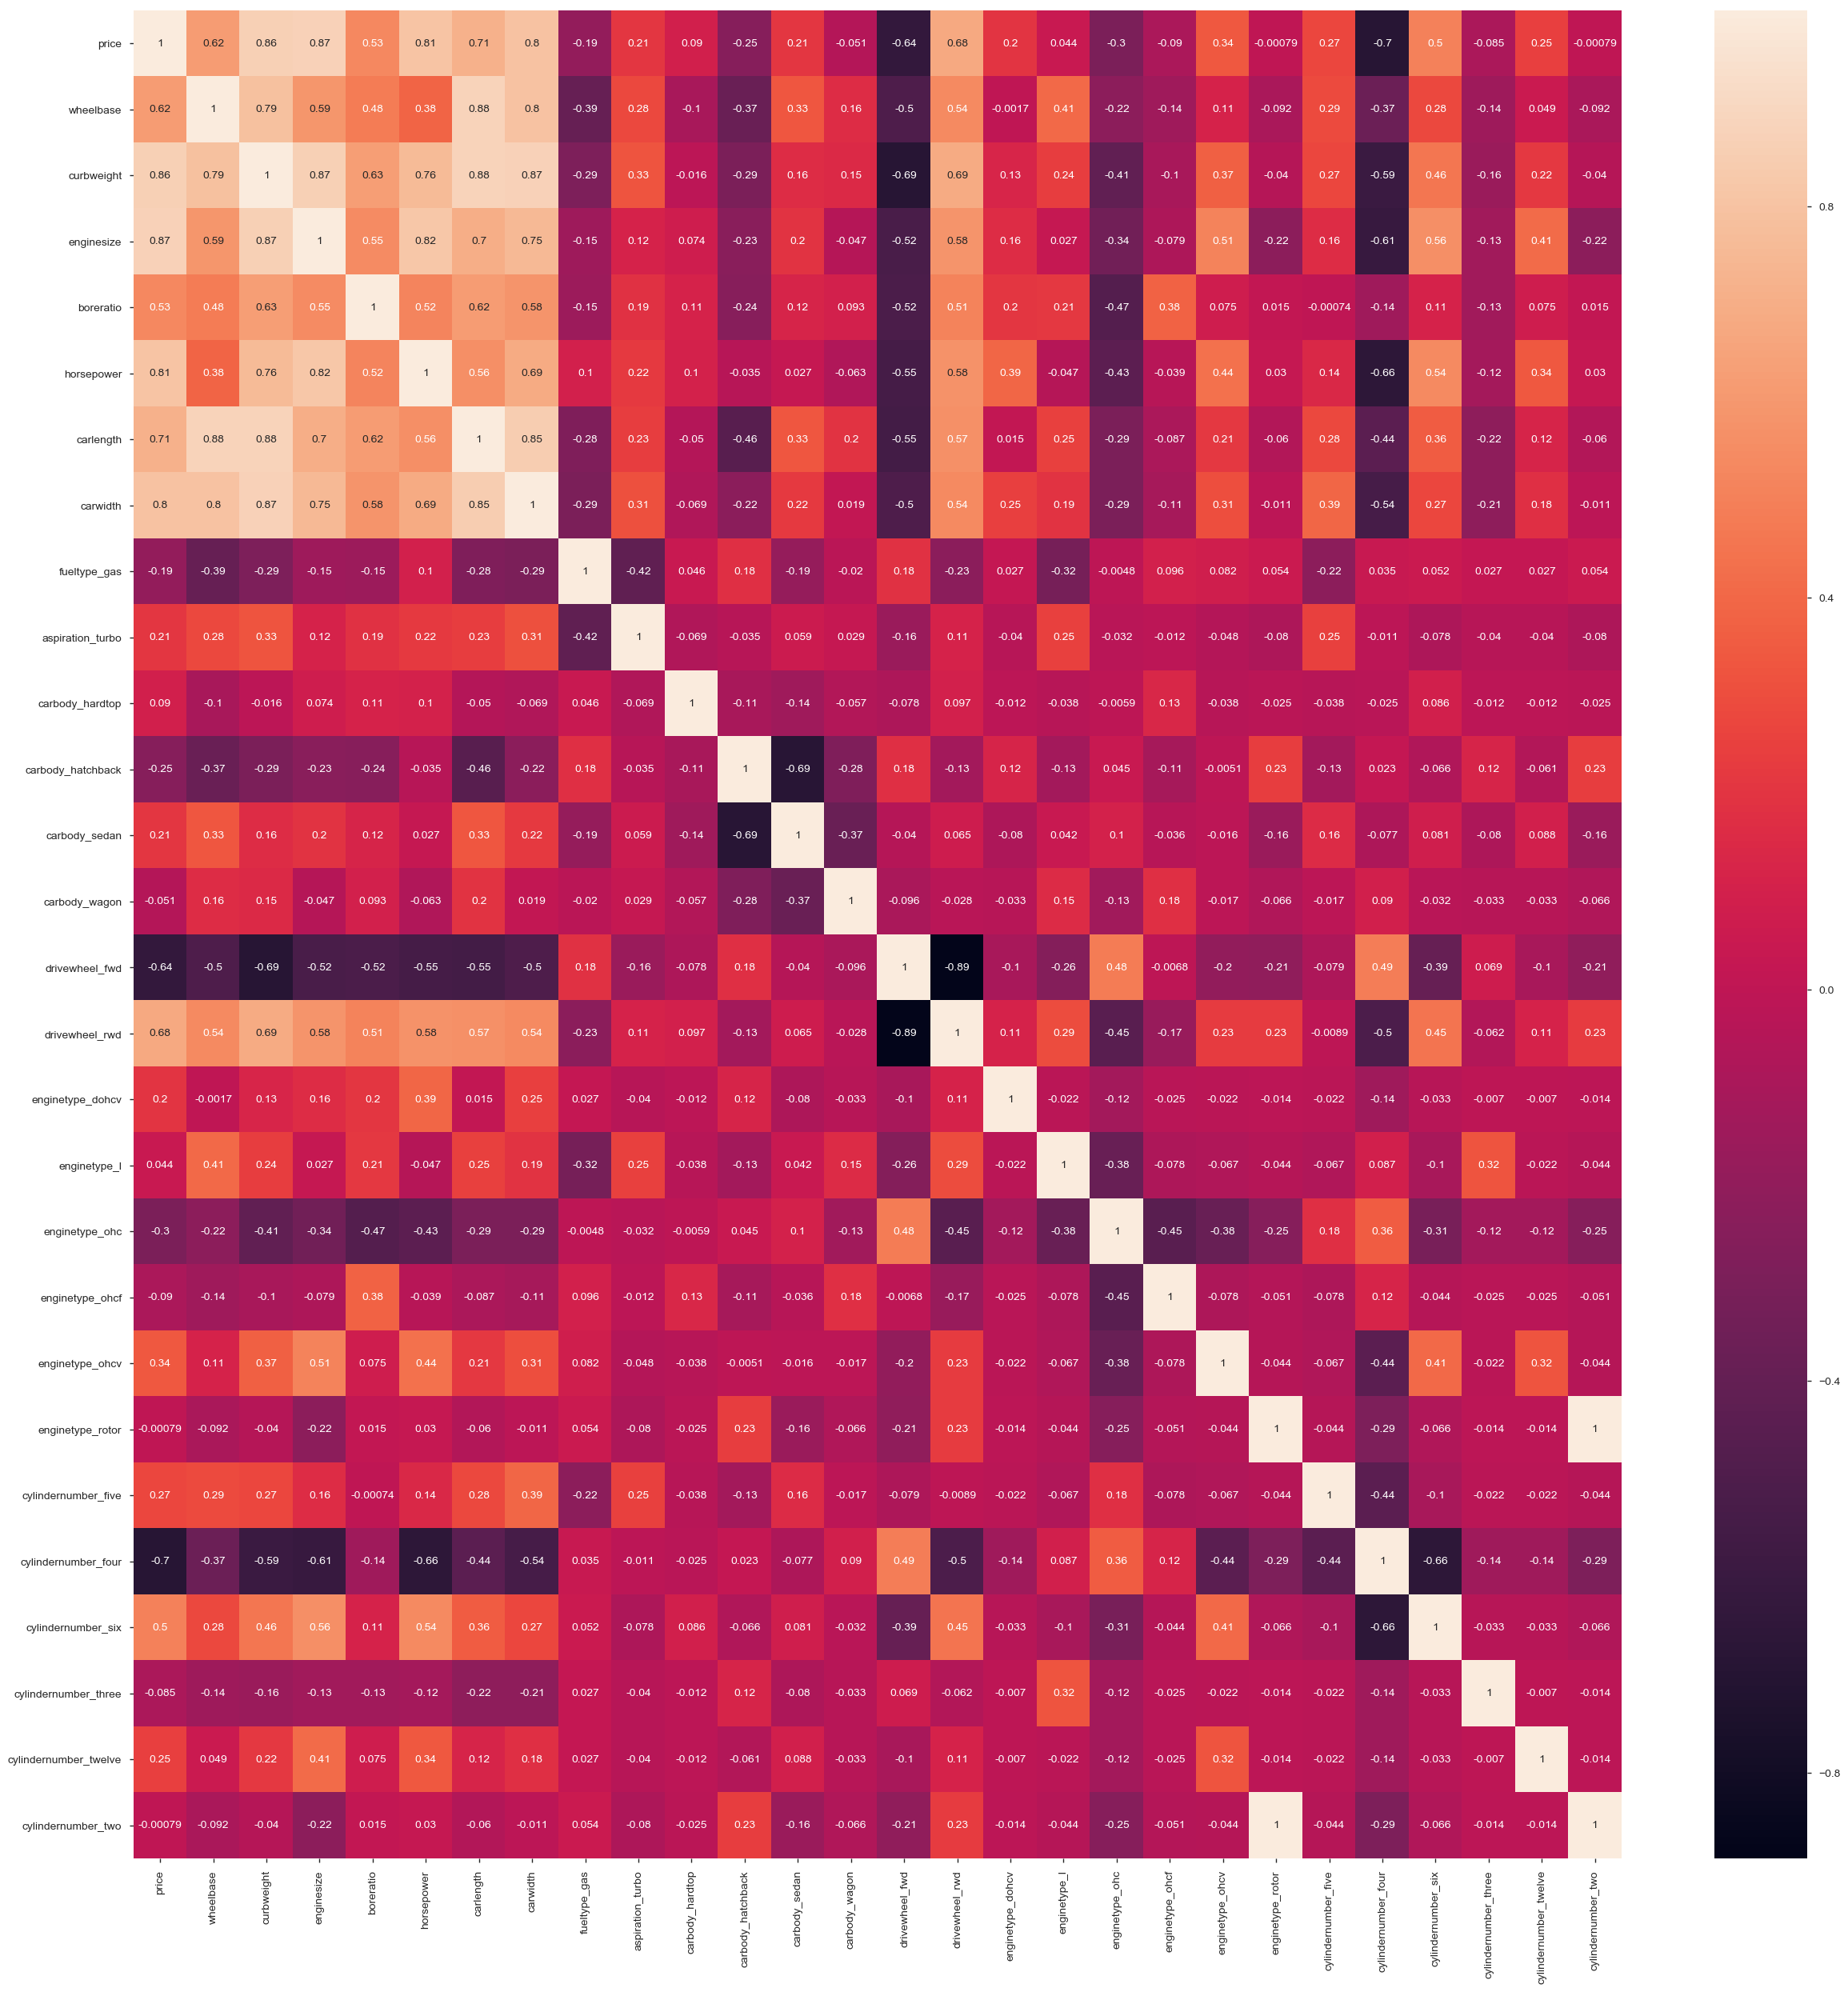

In [21]:
#checking the correlation
plt.figure(figsize = (30, 30))
sns.heatmap(df_train.corr(),annot = True)
plt.show()

In [22]:
#Dividing data into X and y variables
y_train = df_train.pop('price')
X_train = df_train

Building a linear model

In [23]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

In [24]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('wheelbase', False, 4),
 ('curbweight', True, 1),
 ('enginesize', True, 1),
 ('boreratio', False, 14),
 ('horsepower', True, 1),
 ('carlength', False, 2),
 ('carwidth', True, 1),
 ('fueltype_gas', False, 13),
 ('aspiration_turbo', False, 16),
 ('carbody_hardtop', False, 9),
 ('carbody_hatchback', False, 3),
 ('carbody_sedan', False, 6),
 ('carbody_wagon', False, 5),
 ('drivewheel_fwd', False, 18),
 ('drivewheel_rwd', False, 11),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', False, 15),
 ('enginetype_ohc', False, 7),
 ('enginetype_ohcf', False, 8),
 ('enginetype_ohcv', True, 1),
 ('enginetype_rotor', False, 12),
 ('cylindernumber_five', True, 1),
 ('cylindernumber_four', True, 1),
 ('cylindernumber_six', True, 1),
 ('cylindernumber_three', False, 17),
 ('cylindernumber_twelve', True, 1),
 ('cylindernumber_two', False, 10)]

In [25]:
X_train.columns[rfe.support_]

Index(['curbweight', 'enginesize', 'horsepower', 'carwidth',
       'enginetype_dohcv', 'enginetype_ohcv', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_twelve'],
      dtype='object')

In [26]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.corr()

curbweight  enginesize  horsepower  carwidth  \
curbweight               1.000000    0.865102    0.759759  0.873884   
enginesize               0.865102    1.000000    0.817916  0.754925   
horsepower               0.759759    0.817916    1.000000  0.685051   
carwidth                 0.873884    0.754925    0.685051  1.000000   
enginetype_dohcv         0.127791    0.160398    0.393153  0.245699   
enginetype_ohcv          0.370775    0.506634    0.437226  0.305924   
cylindernumber_five      0.273471    0.162473    0.138966  0.392058   
cylindernumber_four     -0.593859   -0.613032   -0.663004 -0.540779   
cylindernumber_six       0.455979    0.561996    0.535827  0.271178   
cylindernumber_twelve    0.218088    0.413197    0.338032  0.181043   

                       enginetype_dohcv  enginetype_ohcv  cylindernumber_five  \
curbweight                     0.127791         0.370775             0.273471   
enginesize                     0.160398         0.506634             0.162473   
horsepower                     0.393153         0.437226             0.138966   
carwidth                       0.245699         0.305924             0.392058   
enginetype_dohcv               1.000000        -0.021748            -0.021748   
enginetype_ohcv               -0.021748         1.000000            -0.067164   
cylindernumber_five           -0.021748        -0.067164             1.000000   
cylindernumber_four           -0.142039        -0.438653            -0.438653   
cylindernumber_six            -0.032849         0.407564            -0.101446   
cylindernumber_twelve         -0.007042         0.323808            -0.021748   

                       cylindernumber_four  cylindernumber_six  \
curbweight                       -0.593859            0.455979   
enginesize                       -0.613032            0.561996   
horsepower                       -0.663004            0.535827   
carwidth                         -0.540779            0.271178   
enginetype_dohcv                 -0.142039           -0.032849   
enginetype_ohcv                  -0.438653            0.407564   
cylindernumber_five              -0.438653           -0.101446   
cylindernumber_four               1.000000           -0.662549   
cylindernumber_six               -0.662549            1.000000   
cylindernumber_twelve            -0.142039           -0.032849   

                       cylindernumber_twelve  
curbweight                          0.218088  
enginesize                          0.413197  
horsepower                          0.338032  
carwidth                            0.181043  
enginetype_dohcv                   -0.007042  
enginetype_ohcv                     0.323808  
cylindernumber_five                -0.021748  
cylindernumber_four                -0.142039  
cylindernumber_six                 -0.032849  
cylindernumber_twelve               1.000000

In [27]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     89.56
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           8.01e-54
Time:                        14:01:50   Log-Likelihood:                 163.68
No. Observations:                 143   AIC:                            -305.4
Df Residuals:                     132   BIC:                            -272.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.02

In [28]:
#Checking the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                   const  36.44
1              curbweight   8.64
2              enginesize   8.19
4                carwidth   5.66
8     cylindernumber_four   5.01
3              horsepower   5.00
9      cylindernumber_six   4.54
7     cylindernumber_five   2.54
10  cylindernumber_twelve   1.94
5        enginetype_dohcv   1.76
6         enginetype_ohcv   1.66

In [29]:
# Dropping highly correlated variables and insignificant variables
X = X_train_lm.drop('curbweight', 1)

In [30]:
# Build a second fitted model
X_train_lm1 = sm.add_constant(X)

lr_1 = sm.OLS(y_train, X_train_lm1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     98.98
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           1.63e-54
Time:                        14:01:50   Log-Likelihood:                 162.88
No. Observations:                 143   AIC:                            -305.8
Df Residuals:                     133   BIC:                            -276.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.02

In [31]:
#Checking the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                  const  36.41
1             enginesize   6.32
7    cylindernumber_four   4.97
2             horsepower   4.78
8     cylindernumber_six   4.51
3               carwidth   3.57
6    cylindernumber_five   2.51
9  cylindernumber_twelve   1.83
5        enginetype_ohcv   1.62
4       enginetype_dohcv   1.58

In [32]:
#Dropping highly correlated value
X = X_train_lm1.drop('enginesize', 1)

In [33]:
# Build a second fitted model
X_train_lm2 = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     72.75
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           5.11e-45
Time:                        14:01:51   Log-Likelihood:                 136.77
No. Observations:                 143   AIC:                            -255.5
Df Residuals:                     134   BIC:                            -228.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.03

In [34]:
#Checking the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                  const  34.76
6    cylindernumber_four   4.75
1             horsepower   4.12
7     cylindernumber_six   3.65
5    cylindernumber_five   2.47
2               carwidth   2.33
3       enginetype_dohcv   1.57
4        enginetype_ohcv   1.57
8  cylindernumber_twelve   1.49

In [35]:
#Dropping highly insignificant value
X = X_train_lm2.drop('cylindernumber_six', 1)

In [36]:
# Build a third fitted model

X_train_lm3 = sm.add_constant(X)

lr_3 = sm.OLS(y_train, X_train_lm3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     83.75
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           5.43e-46
Time:                        14:01:51   Log-Likelihood:                 136.76
No. Observations:                 143   AIC:                            -257.5
Df Residuals:                     135   BIC:                            -233.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.03

In [37]:
#Checking the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_lm3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3.values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                  const  25.96
1             horsepower   3.67
6    cylindernumber_four   2.68
2               carwidth   2.31
5    cylindernumber_five   1.70
4        enginetype_ohcv   1.57
3       enginetype_dohcv   1.30
7  cylindernumber_twelve   1.25

In [38]:
#Dropping highly insignificant value
X = X_train_lm3.drop('cylindernumber_twelve', 1)

In [39]:
# Build a fourth fitted model

X_train_lm4 = sm.add_constant(X)

lr_4 = sm.OLS(y_train, X_train_lm4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     98.16
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           6.10e-47
Time:                        14:01:51   Log-Likelihood:                 136.60
No. Observations:                 143   AIC:                            -259.2
Df Residuals:                     136   BIC:                            -238.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0393    

In [40]:
#check the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_lm3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3.values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                  const  25.96
1             horsepower   3.67
6    cylindernumber_four   2.68
2               carwidth   2.31
5    cylindernumber_five   1.70
4        enginetype_ohcv   1.57
3       enginetype_dohcv   1.30
7  cylindernumber_twelve   1.25

Residual analysis

In [41]:
y_train_price = lr_4.predict(X_train_lm4)

Text(0.5, 0, 'Errors')

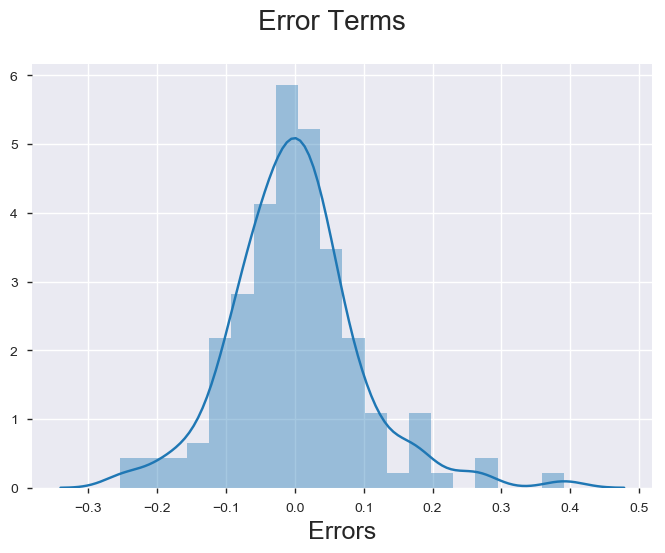

In [42]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

Predictions

In [43]:
#Transforming the categorical variables
variables = df_test.select_dtypes(include =['float64', 'int64'])
var_cols = variables.columns
df_test[var_cols] = scaler.transform(df_test[var_cols])

In [44]:
df_test.describe()

price  wheelbase  curbweight  enginesize  boreratio  horsepower  \
count  62.000000  62.000000   62.000000   62.000000  62.000000   62.000000   
mean    0.239439   0.437764    0.428470    0.265673   0.556580    0.248858   
std     0.233076   0.212861    0.179488    0.162820   0.228484    0.163376   
min     0.007763   0.000000    0.128394    0.067925  -0.111111    0.016667   
25%     0.092342   0.313793    0.305275    0.177358   0.404762    0.107292   
50%     0.158991   0.387931    0.406129    0.226415   0.563492    0.218750   
75%     0.317243   0.570690    0.564876    0.316038   0.746032    0.295833   
max     1.112855   1.182759    0.935609    0.932075   0.888889    0.662500   

       carlength   carwidth  fueltype_gas  aspiration_turbo  ...  \
count  62.000000  62.000000     62.000000         62.000000  ...   
mean    0.559481   0.480376      0.887097          0.177419  ...   
std     0.189947   0.165440      0.319058          0.385142  ...   
min     0.056911   0.183333      0.000000          0.000000  ...   
25%     0.459350   0.358333      1.000000          0.000000  ...   
50%     0.547967   0.441667      1.000000          0.000000  ...   
75%     0.719919   0.516667      1.000000          0.000000  ...   
max     1.089431   0.975000      1.000000          1.000000  ...   

       enginetype_ohc  enginetype_ohcf  enginetype_ohcv  enginetype_rotor  \
count       62.000000        62.000000        62.000000              62.0   
mean         0.806452         0.048387         0.064516               0.0   
std          0.398304         0.216335         0.247676               0.0   
min          0.000000         0.000000         0.000000               0.0   
25%          1.000000         0.000000         0.000000               0.0   
50%          1.000000         0.000000         0.000000               0.0   
75%          1.000000         0.000000         0.000000               0.0   
max          1.000000         1.000000         1.000000               0.0   

       cylindernumber_five  cylindernumber_four  cylindernumber_six  \
count            62.000000            62.000000           62.000000   
mean              0.032258             0.854839            0.080645   
std               0.178127             0.355139            0.274512   
min               0.000000             0.000000            0.000000   
25%               0.000000             1.000000            0.000000   
50%               0.000000             1.000000            0.000000   
75%               0.000000             1.000000            0.000000   
max               1.000000             1.000000            1.000000   

       cylindernumber_three  cylindernumber_twelve  cylindernumber_two  
count                  62.0                   62.0                62.0  
mean                    0.0                    0.0                 0.0  
std                     0.0                    0.0                 0.0  
min                     0.0                    0.0                 0.0  
25%                     0.0                    0.0                 0.0  
50%                     0.0                    0.0                 0.0  
75%                     0.0                    0.0                 0.0  
max                     0.0                    0.0                 0.0  

[8 rows x 28 columns]

In [45]:
#Dividing into X_test and y_test
y_test = df_test.pop('price')
X_test = df_test

In [46]:
# Adding constant variable to test dataframe
X_test_const = sm.add_constant(X_test)

In [47]:
# Creating X_test_const dataframe by dropping variables from X_test_m4
X_test_const = X_test_const[['const', 'horsepower', 'carwidth', 'enginetype_dohcv','enginetype_ohcv', 'cylindernumber_five', 'cylindernumber_four']]

In [48]:
# Making predictions using the fourth model
y_pred = lr_4.predict(X_test_const)

Model Evaluation

In [49]:
r2_score(y_test, y_pred)

0.7713253255339451

Text(0, 0.5, 'y_pred')

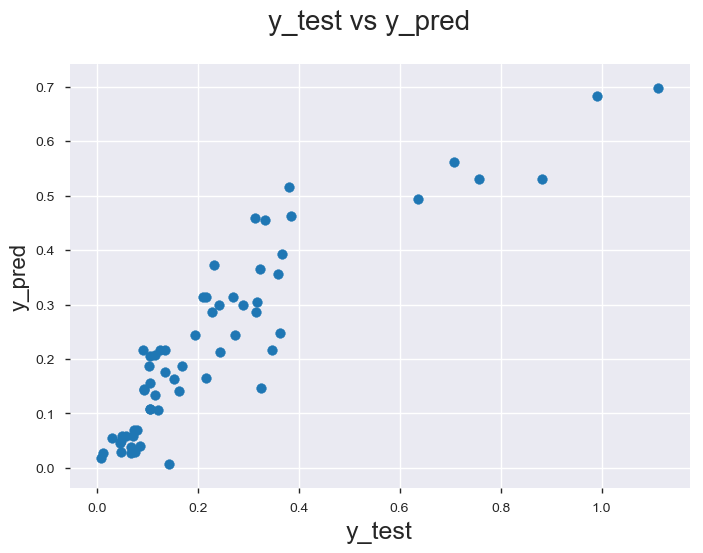

In [50]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)               
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_pred', fontsize = 16)